In [128]:
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.typing import ArrayLike
from scipy.special import lambertw

## Zadanie 5 - Czas ruiny

Niech $X_t$ będzie procesem ruiny modelu Cramera-Lundberga

$$X_t = u+ct - \sum_{i=0}^{N_t} \epsilon_i$$

gdzie $t,c,u \geq 0$, $\epsilon_i$ ~$Exp(\eta)$, $\epsilon_i \perp\!\!\!\perp \epsilon_j$ dla $i \neq j$, $E(\epsilon_i) = \eta$, a $N_t$ jest procesem Poissona o intensywności $\lambda$. Czasem ruiny klasycznej nazywamy zmienną $\tau = inf\{t>0|X_t<0\}$. Prawdopodobieństwem ruiny w czasie nieskończonym nazywamy funkcję $\psi(u,c)=P(\tau<T)$. Wzór Pollaczka-Chinczyna mówi, że:
$$ \psi(u,c) = \dfrac{\eta \lambda}{c} \cdot e^{-(\frac{1}{\eta} -\frac{\lambda}{c})u} $$

Zweryfikuj symulacyjnie ten wynik. W tym celu skorzystaj z pomocniczego prawdopodobieństwa ruiny w czasie skończonym $T$, tj. $\psi(u,c,T)=P(\tau<T)$, $T>0$, dla odpowiednio dużego $T$. Sporządź wykresy funkcji $u \mapsto \psi(u,c_0)$ dla ustalonych wartości $c_0$ oras $c \mapsto \psi(u_0,c)$ dla ustalonych $u_0$ i porównaj je z wartościami wyestymowanymi. Powtórz analizę dla funkcji odwrotnej:

$$c(u, \psi)= \frac{\lambda u}{W_0\left(\dfrac{u\psi e^{\frac{u}{\eta}}}{\eta}\right)}$$

gdzie $W_0$ to gałąź funkcji $W$ Lamberta zdefiniowana poprzez równanie $W_0(xe^x) = x$ dla $x \geq 0$ (scipy.special.lambertw). Ta analiza odpowiada szukaniu wymaganej wartości wpłat przy danym kapitale poczatkowym w celu osiągnięcia wymaganego prawdopodobieństwa ruiny. Zweryfikuj symulacyjnie ten wynik. Tym razem sporządź wykresy funkcji $u \mapsto c(u,\psi_0)$ dla ustalonych $\psi_0$. Pamietaj, że gdy $c \leq \lambda \eta$ to zachodzi $\psi = 1!$.

### $\rightarrow$ ROZWIĄZANIE:

$\textbf{Proces ruiny}$ jest matematycznym modelem używanym do opisu procesów, w których kapitał finansowy może ulegać zmniejszeniu w wyniku losowych strat. Model Cramera-Lundberga opisuje zmiany kapitału $X_t$ w czasie $t$ zgodnie z równaniem:
$$ X_t = u+ct - \sum_{i=0}^{N_t} \epsilon_i$$
gdzie: 

$u$ - kapitał początkowy,

$c$ - premia, 

$N_t$ - proces Poissona, 

$\epsilon_i$ -  niezależne zmienne losowe reprezentujące wielkość strat, $\epsilon_i$~ $Exp(\eta)$,

$\eta$ -  średnia wartość strat,

$\lambda$ - intensywność procesu Poissona.

$\textbf{Czas ruiny}$ to moment, w którym kapitał po raz pierwszy spada do zera lub poniżej zera: $\tau = inf\{t>0|X_t<0\}$

$\textbf{Prawdopodobieństwo ruiny}$ jest to prawdopodobieństwo, że kapitał osiągnie wartość mniejszą bądź równą zero w nieskończonym czasie: $\psi(u,c)=P(\tau<T)$.

### CZĘŚĆ 1
Korzystając z metody Monte Carlo symulacyjnie obliczymy prawdopodobieństwo ruiny i porównamy otrzymane wartości z wartościami teoretycznymi uzyskanymi ze wzoru Pollaczka-Chinczyna:

In [105]:
def process_poiss(T: int, lambda_: float) -> list[float]:
    """Generuj czasy zdarzeń procesu Poissona.

    Parameters
    ----------
    T: int
        Czas trwania symulacji.
    lambda_: float
        Współczynnik intensywności procesu Poissona.

    Returns
    ----------
    S: list[float]
        Lista czasów zdarzeń procesu Poissona w przedziale [0, T].
    """
    S = []
    t = 0
    while True:
        U = np.random.uniform(0, 1)
        t = t - 1 / lambda_ * np.log(U)
        if t > T:
            break
        S.append(t)
    return S

In [106]:
def ruin_process(
    T: int,
    u: float,
    c: float,
    lambda_: float,
    eta: float,
    process: typing.Callable[[int, float], list[float]] = process_poiss,
) -> tuple[ArrayLike, ArrayLike]:
    """Wygeneruj wartości procesu ruiny

    Parameters
    ----------
    T: int
        Czas trwania symulacji.
    u: float
        kapitał początkowy
    c: float
        premia
    lambda_: float
        Współczynnik intensywności procesu Poissona.
    eta: float
        średnia wartość strat
    process
        proces liczący (default process_poiss)

    Returns
    ----------
    tuple[ArrayLike, ArrayLike]
        czas, prawdopodobieństwo ruiny
    """

    N_t = process(T, lambda_)
    epsilons = np.random.exponential(eta, len(N_t))
    t = np.array(N_t)
    X_t = u + c * t
    for i in range(len(N_t)):
        idx = np.where(t >= N_t[i])[0]
        X_t[idx] -= epsilons[i]
    return t, X_t

In [109]:
def prob_ruin(
    N: int, T: float, c: float, u: float, eta: float, lambda_: float
) -> float:
    """Oblicz prawdopodobieństwo ruiny

    Parameters
    ----------
    N: int
        liczba symulacji
    T: int
        Czas trwania symulacji.
    c: float
        premia
    u: float
        kapitał początkowy
    eta: float
        średnia wartość strat
    lambda_: float
        Współczynnik intensywności procesu Poissona.

    Returns
    ----------
    float
        prawdopodobieństwo ruiny
    """
    ruin_count = 0
    for _ in range(N):
        _, X_t = ruin_process(T, u, c, lambda_, eta)
        if np.min(X_t) < 0:
            ruin_count += 1
    return ruin_count / N

In [110]:
def pollaczek(eta: float, lambda_: float, c: float, u: float) -> float:
    """Oblicz prawdopodobieństwo ruiny

    Parameters
    ----------
    eta: float
        średnia wartość strat
    lambda_: float
        Współczynnik intensywności procesu Poissona.
    c: float
        premia
    u: float
        kapitał początkowy

    Returns
    ----------
    float
        prawdopodobieństwo ruiny
    """
    psi = (eta * lambda_) / c * np.exp(-((1 / eta) - (lambda_ / c)) * u)
    if c > lambda_ * eta:
        return psi
    else:
        return 1.0

In [111]:
eta = 8
lambda_ = 2
T_end = 200
N = 1000
c = 20
u = 100

In [112]:
u_val = np.linspace(0, 100, 100)
c_val = np.linspace(20, 30, 100)
u0_val = [10, 30, 50]
c0_val = [20, 25, 30]
eta = 8
lambda_ = 2
T_end = 200
N = 500

In [115]:
theo_psi_c0 = np.zeros((len(c0_val), len(u_val)))
sim_psi_c0 = np.zeros((len(c0_val), len(u_val)))

for j, c0 in enumerate(c0_val):
    for i, u in enumerate(u_val):
        sim_psi_c0[j, i] = prob_ruin(N=N, T=T_end, c=c0, u=u, eta=eta, lambda_=lambda_)
        theo_psi_c0[j, i] = pollaczek(eta, lambda_, c0, u)

Poniższy wykres ($u \mapsto \psi(u, c_0)$) przedstawia zestawienie wyników estymowanych wraz z wynikami teoretycznymi (Pollaczek-Chinczyn) dla wybranych wartości $c_0$. Jak widać, wyniki estymacji są zgodne z wynikami teoretycznymi.

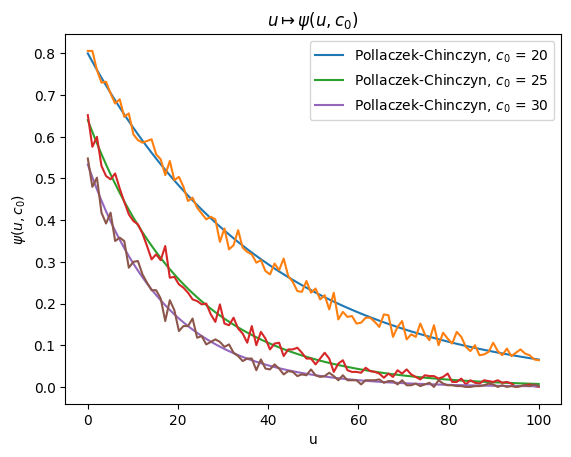

In [116]:
plt.plot(u_val, theo_psi_c0[0], label=f"Pollaczek-Chinczyn, $c_0$ = {c0_val[0]}")
plt.plot(u_val, sim_psi_c0[0])

plt.plot(u_val, theo_psi_c0[1], label=f"Pollaczek-Chinczyn, $c_0$ = {c0_val[1]}")
plt.plot(u_val, sim_psi_c0[1])

plt.plot(u_val, theo_psi_c0[2], label=f"Pollaczek-Chinczyn, $c_0$ = {c0_val[2]}")
plt.plot(u_val, sim_psi_c0[2])

plt.xlabel("u")
plt.ylabel("$\psi(u, c_0)$")
plt.title(("$u \mapsto \psi(u, c_0)$"))
plt.legend()
plt.show()

In [117]:
theo_psi_u0 = np.zeros((len(u0_val), len(c_val)))
sim_psi_u0 = np.zeros((len(u0_val), len(c_val)))

for j, u0 in enumerate(u0_val):
    for i, c in enumerate(c_val):
        sim_psi_u0[j, i] = prob_ruin(N=N, T=T_end, c=c, u=u0, eta=eta, lambda_=lambda_)
        theo_psi_u0[j, i] = pollaczek(eta, lambda_, c, u0)

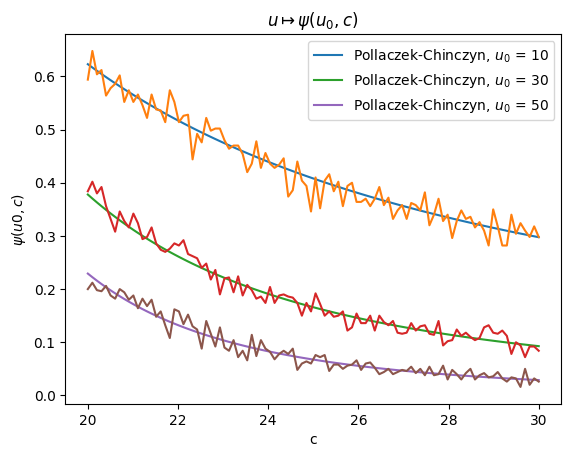

In [118]:
plt.plot(c_val, theo_psi_u0[0], label=f"Pollaczek-Chinczyn, $u_0$ = {u0_val[0]}")
plt.plot(c_val, sim_psi_u0[0])

plt.plot(c_val, theo_psi_u0[1], label=f"Pollaczek-Chinczyn, $u_0$ = {u0_val[1]}")
plt.plot(c_val, sim_psi_u0[1])

plt.plot(c_val, theo_psi_u0[2], label=f"Pollaczek-Chinczyn, $u_0$ = {u0_val[2]}")
plt.plot(c_val, sim_psi_u0[2])

plt.xlabel("c")
plt.ylabel("$\psi(u0, c)$")
plt.title(("$u \mapsto \psi(u_0, c)$"))
plt.legend()
plt.show()

### CZĘŚĆ 2
Funkcja W Lamberta, jest zdefiniowana jako odwrotność funkcji $f(w) = w e^w$, gdzie $w$ jest liczbą zespoloną. Oznacza się ją jako $W(z)$, a ponieważ $f$ nie jest iniekcją otrzymujemy rodzinę funkcji $W_k ( z )$, gdzie $k \in \mathbb{Z}$ oznacza numer gałęzi. $W_0$ jest znane jako gałąź główna:
$W_0(we^w) = w$ dla $w \geq 0$.

Wiedząc to możemy obliczyć: 
$$c(u, \psi)= \frac{\lambda u}{W_0\left(\dfrac{u\psi e^{\frac{u}{\eta}}}{\eta}\right)}$$

W tej części również porównamy uzyskany wynik teoretyczny z wynikami estymowanymi:

In [119]:
def inverse_c(u, psi, lambda_, eta):
    W = u * psi * np.exp(u / eta) / eta
    return lambda_ * u / lambertw(W).real

In [120]:
def estimate_c(u, psi, eta, lambda_, N, T_end, error=0.001):
    c_start = 0
    c_end = 50

    while True:
        c = (c_start + c_end) / 2
        prob = prob_ruin(N=N, T=T_end, c=c, u=u, eta=eta, lambda_=lambda_)

        if np.abs(psi - prob) < error:
            return c
        elif prob > psi:
            c_start = c
        else:
            c_end = c

In [121]:
psi0_val = [0.2, 0.4, 0.6]
u_val = np.linspace(10, 100, 50)
eta = 8
lambda_ = 2
T_end = 200
N = 300

In [123]:
theo_estimate_c = np.zeros((len(psi0_val), len(u_val)))
# sim_estimate_c = np.zeros((len(psi0_val), len(u_val)))

for j, psi0 in enumerate(psi0_val):
    for i, u in enumerate(u_val):
        # sim_estimate_c[j, i] = estimate_c(u=u, psi=psi0, eta=eta, lambda_ = lambda_, N = N, T_end = T_end)
        theo_estimate_c[j, i] = inverse_c(u=u, psi=psi0, lambda_=lambda_, eta=eta)

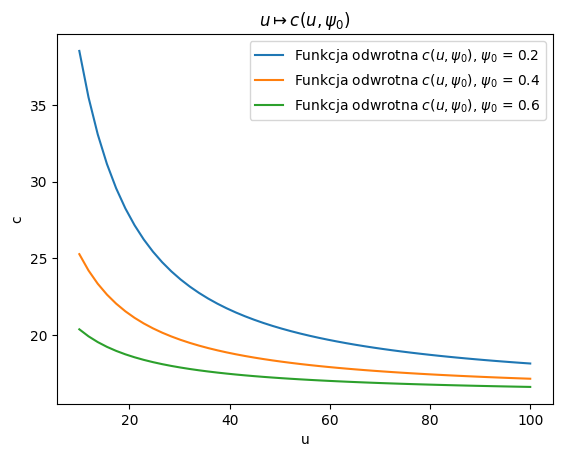

In [131]:
plt.plot(
    u_val,
    theo_estimate_c[0],
    label=f"Funkcja odwrotna $c(u,\psi_0)$, $\psi_0$ = {psi0_val[0]}",
)
# plt.plot(u_val, sim_estimate_c[0])

plt.plot(
    u_val,
    theo_estimate_c[1],
    label=f"Funkcja odwrotna $c(u,\psi_0)$, $\psi_0$ = {psi0_val[1]}",
)
# plt.plot(u_val, sim_estimate_c[1])

plt.plot(
    u_val,
    theo_estimate_c[2],
    label=f"Funkcja odwrotna $c(u,\psi_0)$, $\psi_0$ = {psi0_val[2]}",
)
# plt.plot(u_val, sim_estimate_c[2])

plt.xlabel("u")
plt.ylabel("c")
plt.title(("$u \mapsto c(u, \psi_0)$"))
plt.legend()
plt.show()

Poniżej przedstawiono zestawienie wartości $c$ (teoretyczne vs estymowane) dla różnych wartości $\psi_0$. 

- Parametry: $u=5, \, \eta = 8, \, \lambda = 1, \, N = 200, \,T = 200$

In [145]:
c1_e_5 = estimate_c(u=5, psi=0.2, eta=8, lambda_=1, N=200, T_end=200)
c1_theo_5 = inverse_c(u=5, psi=0.2, lambda_=1, eta=8)

c2_e_5 = estimate_c(u=5, psi=0.4, eta=8, lambda_=1, N=200, T_end=200)
c2_theo_5 = inverse_c(u=5, psi=0.4, lambda_=1, eta=8)

c3_e_5 = estimate_c(u=5, psi=0.6, eta=8, lambda_=1, N=200, T_end=200)
c3_theo_5 = inverse_c(u=5, psi=0.6, lambda_=1, eta=8)

c4_e_5 = estimate_c(u=5, psi=0.8, eta=8, lambda_=1, N=200, T_end=200)
c4_theo_5 = inverse_c(u=5, psi=0.8, lambda_=1, eta=8)

In [146]:
data_5 = {
    "estymowane c": [c1_e_5, c2_e_5, c3_e_5, c4_e_5],
    "teoretyczne c": [c1_theo_5, c2_theo_5, c3_theo_5, c4_theo_5],
}
index_5 = ["psi = 0.2", "psi = 0.4", "psi = 0.6", "psi = 0.8"]
df_5 = pd.DataFrame(data_5, index=index_5)

In [147]:
df_5

,estymowane c,teoretyczne c
psi = 0.2,26.159668,25.958402
psi = 0.4,14.590452,14.955257
psi = 0.6,10.937500,11.167401
psi = 0.8,9.234256,9.211095


- Parametry: $u=20, \, \eta = 8, \, \lambda = 1, \, N = 200, \,T = 200$

In [142]:
c1_e_20 = estimate_c(u=20, psi=0.2, eta=8, lambda_=1, N=200, T_end=200)
c1_theo_20 = inverse_c(u=20, psi=0.2, lambda_=1, eta=8)

c2_e_20 = estimate_c(u=20, psi=0.4, eta=8, lambda_=1, N=200, T_end=200)
c2_theo_20 = inverse_c(u=20, psi=0.4, lambda_=1, eta=8)

c3_e_20 = estimate_c(u=20, psi=0.6, eta=8, lambda_=1, N=200, T_end=200)
c3_theo_20 = inverse_c(u=20, psi=0.6, lambda_=1, eta=8)

c4_e_20 = estimate_c(u=20, psi=0.8, eta=8, lambda_=1, N=200, T_end=200)
c4_theo_20 = inverse_c(u=20, psi=0.8, lambda_=1, eta=8)

In [143]:
data_20 = {
    "estymowane c": [c1_e_20, c2_e_20, c3_e_20, c4_e_20],
    "teoretyczne c": [c1_theo_20, c2_theo_20, c3_theo_20, c4_theo_20],
}
index_20 = ["psi = 0.2", "psi = 0.4", "psi = 0.6", "psi = 0.8"]
df_20 = pd.DataFrame(data_20, index=index_20)

In [144]:
df_20

,estymowane c,teoretyczne c
psi = 0.2,13.909912,13.876320
psi = 0.4,10.620117,10.680069
psi = 0.6,9.387970,9.331944
psi = 0.8,8.291626,8.539347


- Parametry: $u=80, \, \eta = 8, \, \lambda = 1, \, N = 200, \,T = 200$

In [139]:
c1_e_80 = estimate_c(u=80, psi=0.2, eta=8, lambda_=1, N=200, T_end=200)
c1_theo_80 = inverse_c(u=80, psi=0.2, lambda_=1, eta=8)

c2_e_80 = estimate_c(u=80, psi=0.4, eta=8, lambda_=1, N=200, T_end=200)
c2_theo_80 = inverse_c(u=80, psi=0.4, lambda_=1, eta=8)

c3_e_80 = estimate_c(u=80, psi=0.6, eta=8, lambda_=1, N=200, T_end=200)
c3_theo_80 = inverse_c(u=80, psi=0.6, lambda_=1, eta=8)

c4_e_80 = estimate_c(u=80, psi=0.8, eta=8, lambda_=1, N=200, T_end=200)
c4_theo_80 = inverse_c(u=80, psi=0.8, lambda_=1, eta=8)

In [140]:
data_80 = {
    "estymowane c": [c1_e_80, c2_e_80, c3_e_80, c4_e_80],
    "teoretyczne c": [c1_theo_80, c2_theo_80, c3_theo_80, c4_theo_80],
}
index_80 = ["psi = 0.2", "psi = 0.4", "psi = 0.6", "psi = 0.8"]
df_80 = pd.DataFrame(data_80, index=index_80)

In [141]:
df_80

,estymowane c,teoretyczne c
psi = 0.2,9.277344,9.359454
psi = 0.4,8.529663,8.723794
psi = 0.6,8.015444,8.388716
psi = 0.8,7.473755,8.165489
